# Imports & CO

install not pre-installed libs

In [ ]:
!pip install torchmetrics && pip install torch_pruning && pip install mapcalc

     |████████████████████████████████| 408 kB 4.8 MB/s 


In [1]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##--- default imports ---
import numpy as np
import pandas as pd
import random
from random import randrange
import os
import time
from datetime import datetime

## --- file handling ---
import json
import ast # for json
import pickle

## --- visualization ---
import cv2
import PIL.Image as Image
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
plt.ioff() # turns interactive mode off

## --- Dataset ---
from pycocotools.coco import COCO

## --- Model ---
import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

## --- Metrics ---
from torchmetrics.functional import pairwise_cosine_similarity
from torchmetrics.detection.mean_ap import MeanAveragePrecision as MAP
from torchmetrics import AveragePrecision
from mapcalc import calculate_map, calculate_map_range

## --- Pruning ---
import torch_pruning as tp
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

# Dataset
load annotations

In [ ]:
# loading filenames
def getFileNames(max_samples=100):
  '''
  returns fileNames of given directory as an array

  Parameters:
  max_samples (int): Maximum amount of files considered (default = 100)

  Returns:
  file_names (str[]): filenames

  '''

  # paths to annotations & images
  json_path = '/content/drive/MyDrive/DHBW/BA/COCO2017/annotations/instances_val2017.json'
  img_path = "/content/drive/MyDrive/DHBW/BA/COCO2017/val2017"

  # load coco data
  coco = COCO(annotation_file=json_path)

  # get all image index info
  ids = list(sorted(coco.imgs.keys()))

  file_names = []
  for img_id in ids[:max_samples]:
    # get image file name
    path = coco.loadImgs(img_id)[0]['file_name']
    file_names.append(os.path.join(img_path, path))

  return file_names

# save filenames in a variable
selected_file_names = getFileNames(max_samples=1000)
print(len(selected_file_names))

loading annotations into memory...
Done (t=1.44s)
creating index...
index created!
1000


In [ ]:
# loading annotations
def getAnnotations(max_samples=100):
  '''
  loading annotations from given COCO annotation file as array 

  Parameters:
  max_samples (int): Maximum amount of files considered (default = 100)

  Returns:
  list(object[]): array of annotations, every instance is a dictionary

  '''

  # paths to annotation file and images
  json_path = '/content/drive/MyDrive/DHBW/BA/COCO2017/annotations/instances_val2017.json'
  img_path = "/content/drive/MyDrive/DHBW/BA/COCO2017/val2017"

  # variables
  annotations = []

  # load coco data
  coco = COCO(annotation_file=json_path)

  # get all image index info
  ids = list(sorted(coco.imgs.keys()))
  print("number of images: {}".format(len(ids)))

  # get all coco class labels
  coco_classes = dict([(v["id"], v["name"]) for k, v in coco.cats.items()])

  #  Traverse the first x images 
  for img_id in ids[:max_samples]:
      #  Obtain the corresponding image id All of the annotations idx Information 
      ann_ids = coco.getAnnIds(imgIds=img_id)

      #  according to annotations idx Information get all annotation information 
      targets = coco.loadAnns(ann_ids)

      # get image file name
      path = coco.loadImgs(img_id)[0]['file_name']
      
      # read image
      img = Image.open(os.path.join(img_path, path)).convert('RGB')
      draw = ImageDraw.Draw(img)

      singleImage_annotation_boxes = []
      singleImage_annotation_labels = []
      for target in targets:
        x, y, w, h = target["bbox"]
        x1, y1, x2, y2 = x, y, int(x + w), int(y + h)

        # append coordinates to array
        singleImage_annotation_boxes.append([x1,y1,x2,y2])
        # append label to array
        singleImage_annotation_labels.append(target["category_id"])
        
        # draw rectangle
        draw.rectangle((x1, y1, x2, y2))
        draw.text((x1, y1), coco_classes[target["category_id"]])

      data = {
          'boxes' : torch.tensor(np.array(singleImage_annotation_boxes)),
          'labels' : torch.tensor(np.array(singleImage_annotation_labels))
      }
      annotations.append(data)
      # print(target['image_id'])
      # show image
      # plt.imshow(img)
      # plt.show()
    
  return list(annotations)

anns = getAnnotations(max_samples=1000)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
number of images: 5000


In [ ]:
# array with category names
COCO_INSTANCE_CATEGORY_NAMES = [
                                '__background__', 
                                'person', 
                                'bicycle', 
                                'car', 
                                'motorcycle', 
                                'airplane', 
                                'bus',
                                'train', 
                                'truck', 
                                'boat', 
                                'traffic light', 
                                'fire hydrant', 
                                'N/A', 
                                'stop sign',
                                'parking meter', 
                                'bench', 
                                'bird', 
                                'cat', 
                                'dog', 
                                'horse', 
                                'sheep', 
                                'cow',
                                'elephant', 
                                'bear', 
                                'zebra', 
                                'giraffe', 
                                'N/A', 
                                'backpack', 
                                'umbrella', 
                                'N/A', 
                                'N/A',
                                'handbag', 
                                'tie', 
                                'suitcase', 
                                'frisbee', 
                                'skis', 
                                'snowboard', 
                                'sports ball',
                                'kite', 
                                'baseball bat', 
                                'baseball glove', 
                                'skateboard', 
                                'surfboard', 
                                'tennis racket',
                                'bottle', 
                                'N/A', 
                                'wine glass', 
                                'cup', 
                                'fork', 
                                'knife', 
                                'spoon', 
                                'bowl',
                                'banana', 
                                'apple', 
                                'sandwich', 
                                'orange', 
                                'broccoli', 
                                'carrot', 
                                'hot dog', 
                                'pizza',
                                'donut', 
                                'cake', 
                                'chair', 
                                'couch', 
                                'potted plant', 
                                'bed', 
                                'N/A', 
                                'dining table',
                                'N/A', 
                                'N/A', 
                                'toilet', 
                                'N/A', 
                                'tv', 
                                'laptop', 
                                'mouse', 
                                'remote', 
                                'keyboard', 
                                'cell phone',
                                'microwave', 
                                'oven', 
                                'toaster', 
                                'sink', 
                                'refrigerator', 
                                'N/A', 
                                'book',
                                'clock', 
                                'vase', 
                                'scissors', 
                                'teddy bear', 
                                'hair drier', 
                                'toothbrush'
]

# Utils functions

## Pretrained Model

pretrained COCO resnet50 fpn

In [ ]:
def loadPretrainedModel():
  '''
  loading a pretrained (COCO 2017) Mask R-CNN with a resnet 50 fpn backbone

  Params:
  - 
  
  Returns:
  model(pytorchModel()) : loaded model
  '''

  # load model from pytorch
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  return model


In [ ]:
def putModelInEvalMode(model):
  '''
  putting model in evaluation mode

  Params:
  model(pytorchModel()): model in train mode
  
  Returns:
  model(pytorchModel()) : model in evaluation mode
  '''
  model.eval()
  return model

## Mean-Average-Precision

In [ ]:
# calcuate MAP
def calculateMAP(ground_truth_boxes, ground_truth_labels, result_dict_boxes, result_dict_labels, result_dict_scores):
  '''
  Calculating the Mean-Average-Precision per Image

  Parameters:
  grount_truth_boxes(float[]): boxes of ground truth (x1,y1,x2,y2)
  ground_truth_labels(int[]): labels of ground truth 
  result_dict_boxes(float[]): boxes of prediction (x1,y1,x2,y2)
  result_dict_labels(int[]): labels of prediction
  result_dict_scores(float[]): scores of prediction

  Returns:
  calculate_map(ground_truth, result_dict, 0.5)(float[]): Average Precision per Image with threshold IoU@0.5

  '''

  # try 
  try:
    # saving data in fitting format
    ground_truth_boxes_fittingFormat = []
    if len(ground_truth_boxes) == 1:
      list = []
      list.append(ground_truth_boxes[0][0][0])
      list.append(ground_truth_boxes[0][0][1])
      list.append(ground_truth_boxes[0][1][0])
      list.append(ground_truth_boxes[0][1][1])
      ground_truth_boxes_fittingFormat.append(list)

    else:
      for i in  range(len(ground_truth_boxes)):
        list = []
        list.append(ground_truth_boxes[i][0][0])
        list.append(ground_truth_boxes[i][0][1])
        list.append(ground_truth_boxes[i][1][0])
        list.append(ground_truth_boxes[i][1][1])
        ground_truth_boxes_fittingFormat.append(list)  

    result_dict_boxes_fittingFormat = []
    if len(result_dict_boxes) == 1:
      list = []
      list.append(result_dict_boxes[0][0][0])
      list.append(result_dict_boxes[0][0][1])
      list.append(result_dict_boxes[0][1][0])
      list.append(result_dict_boxes[0][1][1])
      result_dict_boxes_fittingFormat.append(list)
    else:
      for i in  range(len(result_dict_boxes)):
        list = []
        list.append(result_dict_boxes[i][0][0])
        list.append(result_dict_boxes[i][0][1])
        list.append(result_dict_boxes[i][1][0])
        list.append(result_dict_boxes[i][1][1])
        result_dict_boxes_fittingFormat.append(list)

    ground_truth_labels_fittingFormat = []
    for i in range(len(ground_truth_labels)):
      ground_truth_labels_fittingFormat.append(ground_truth_labels[i].item())
    
    result_dict_labels_fittingFormat = []
    for i in range(len(result_dict_labels)):
      label = result_dict_labels[i]
      for j in range(len(COCO_INSTANCE_CATEGORY_NAMES)):
        if label == COCO_INSTANCE_CATEGORY_NAMES[j]:
          label_num = j
          result_dict_labels_fittingFormat.append(label_num)

    # build dictionary from given data 
    ground_truth = {
        'boxes' : ground_truth_boxes_fittingFormat,
        'labels': ground_truth_labels_fittingFormat
    }

    result_dict = {
        'boxes' : result_dict_boxes_fittingFormat,
        'labels': result_dict_labels_fittingFormat,
        'scores': np.ones(len(result_dict_boxes_fittingFormat)).tolist(),
    }

    # return map[IoU@0.5]
    return calculate_map(ground_truth, result_dict, 0.5)
  
  # catch Errors
  except:
    # print detail infos for errors
    print("ERROR\nlen(ground_truth_boxes): {} len(result_dict_boxes) {}".format(len(ground_truth_boxes),len(result_dict_boxes)))
    print("ground_truth_boxes: ", ground_truth_boxes)
    print("result_dict_boxes: ", result_dict_boxes)

    # return -1, will be removed in next step
    return -1
  

## Colour Mask

In [ ]:
# every mask different color
def random_colour_masks(image):
  '''
  Calculate random colour masks

  Parameters:
  image (float[]): mask

  Returns:
  coloured_mask (int[]): colour array

  '''
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  
  return coloured_mask

## Predictions

In [ ]:
def get_prediction(img_path, threshold, model):
  '''
  Predicts classes for given images

  Parameters:
  img_path (str): Path to plank image
  threshold (float): score threshold for predicted class
  model (pytrochModel): model to use for prediction

  Returns:
  masks (float[]): pixel information for masks
  pred_boxes (float[]): box coordinates for bounding boxes
  pred_classes (str[]): classes of predictions
  pred_score (float[]): scores of classes

  '''

  model = model
  
  # read Image & transform to Tensor
  # print("img_path: ", img_path)
  img = Image.open(img_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)

  #prediction
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  scores_greater_threshold = False
  # print("threshold: ", threshold)
  for x in pred_score:
    if x > threshold:
      scores_greater_threshold = True
  # print("pred_score: ", pred_score)
  # print("scores_greater_threshold: ", scores_greater_threshold)
  if scores_greater_threshold:
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    # masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    # masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
  else: 
    pred_boxes = []
    pred_class = []
    pred_score = []


  # return masks, pred_boxes, pred_class, pred_score
  return pred_boxes, pred_class, pred_score


## Complete Pipeline

In [ ]:
def instance_segmentation_api(img_path, id, model, threshold=0.5, rect_th=1, text_size=0.3, text_th=1, groundTruth=True, prediction=True, visualize=True, printIntermediateResults=True, outputDir=""):
  '''
  complete pipeline to predict, visualize and evaluate (mAP) single Images

  Parameters:
  img_path (str): path to image 
  id (int): id of array where image is saved
  model (Pytorch model): prediction model
  threshold (float): threshold for prediction (default=0.5)
  rect_th (int): Thickness of rectangle (default=1)
  text_size (float): Text size (default=0.3)
  text_th (float): Thickness of Text (default=1)
  groundTruth (Boolean): if True, calculate ground truth, if False don't (default=True)
  prediction (Boolean): if True, calculate prediction, if False don't (default=True)
  visualize (Boolean): if True, visualize calculations/ predictions, if False don't (default=True)
  printIntermediateResults (Boolean): if True, print intermediate results, if False don't (default=True)
  outputDir (str): directory to store the output image
  '''

  # get prediction
  boxes, pred_cls, pred_scores = get_prediction(img_path, threshold, model)
  # print("prediction")

  # get annotation
  boxes_anns = anns[id]['boxes']
  labels_anns = anns[id]['labels']
  # print("anns")

  # read image
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # print("read Img")

  # visualize prediction and ground truth if required 
  # print("len(boxes): {}; len(boxes_anns): {} ".format(len(boxes), len(boxes_anns)))
  if len(boxes) != 0 and len(boxes_anns) != 0:
    if prediction and (visualize or outputDir!=""):
      for i in range(len(boxes)):
        # rgb_mask = random_colour_masks(masks[i])
        # img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

    # print("prediction")

    if groundTruth:
      labels_anns_str = []
      boxes_anns_float = []
      for i in range(len(boxes_anns)):
        boxes_a = [(np.float32(boxes_anns[i][0].item()), np.float32(boxes_anns[i][1].item())), (np.float32(boxes_anns[i][2].item()), np.float32(boxes_anns[i][3].item()))]
        label = COCO_INSTANCE_CATEGORY_NAMES[labels_anns[i].item()]
        labels_anns_str.append(label)
        boxes_anns_float.append(boxes_a)
        if visualize or outputDir !="":
          cv2.rectangle(img, boxes_a[0], boxes_a[1],color=(255, 0, 0), thickness=1)
          cv2.putText(img,label,boxes_a[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)

    # print("groundTruth")

    mAP = calculateMAP(
        ground_truth_boxes = boxes_anns_float,
        ground_truth_labels = labels_anns,
        result_dict_boxes= boxes,
        result_dict_labels= pred_cls,
        result_dict_scores = pred_scores
      )
    
    # print("map")
    
    if printIntermediateResults:
      print("img\t\t\t: {}".format(img_path))
      print("predicted classes\t: {}".format(pred_cls))
      print("ground truth classes\t: {}".format(labels_anns_str))
      print("mAP[IoU@0.5]\t\t: {}".format(mAP))

    if mAP == -1 or mAP == -2:
      print("ERROR id: {} img: {}".format(id, img_path))
      
    if outputDir != "":
      # print("saving img - 1")
      new_image_path = img_path.split("/")[-1]
      # print("img_path: ", img_path)
      # print("saving img - 2")
      new_image_path = os.path.join(outputDir, new_image_path)
      # print("outputDir: ", outputDir)
      # print("new_image_path: ",new_image_path)
      # print("saving img - 3")
      fig = plt.figure(figsize=(20,30))
      plt.imshow(img)
      # print("saving img - 3-1")
      plt.xticks([])
      plt.yticks([])
      fig.savefig(new_image_path)
      plt.close(fig)
      # print("saving img - 4")
      if printIntermediateResults:
        print("image saved\t\t: ",new_image_path )

      # print("saving Img")

    if visualize:
      plt.figure(figsize=(20,30))
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      plt.show()

    # print("before results ")
    # print("boxes: ", boxes)
    # print("pred_cls: ", pred_cls)
    # print("pred_scores: ", pred_scores)
    # print("boxes_anns: ", boxes_anns)
    # print("labels_anns: ", labels_anns)
    # print("mAP: ", mAP)
    
    # print(type(labels_anns))
    results = {
        'prediction': {
            'boxes': boxes,
            'labels': pred_cls,
            'scores': pred_scores
        },
        'annotation': {
            'boxes' : boxes_anns,
            'labels': labels_anns 
        },
        'metric': {
            'map[IoU@0.5]': mAP
        }
    }

    # print("results")


  
  else:
    results = {
        'prediction': {
            'boxes': [],
            'labels': [],
            'scores': []
        },
        'annotation': {
            'boxes' : [],
            'labels': [] 
        },
        'metric': {
            'map[IoU@0.5]': -2
        }
    }

  return results


## Pruning

### weight pruning - global - unstructured 

In [ ]:
def prune_global_unstructured(model_to_prune, proportion):
  '''
  pruning a model. Unstructured & global

  Params:
  model_to_prune(pytorchModel()): model in evaluation model
  proportion(float()): percentage of pruned params

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''
  
    module_tups = []
    for module in model_to_prune.modules():
      if isinstance(module, torch.nn.Conv2d):
        module_tups.append((module, 'weight'))
      elif isinstance(module, torch.nn.Linear):
        module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')

    return model_to_prune

### weight pruning - global - unstructured - only Conv2D Layers

In [ ]:
def prune_global_unstructured_onlyConv2DLayers(model_to_prune, proportion):
   '''
  pruning a model. Unstructured & global & onlyConv2DLayers

  Params:
  model_to_prune(pytorchModel()): model in evaluation model
  proportion(float()): percentage of pruned params

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''

    module_tups = []
    for module in model_to_prune.modules():
      if isinstance(module, torch.nn.Conv2d):
        module_tups.append((module, 'weight'))

    prune.global_unstructured(
        parameters=module_tups, pruning_method=prune.L1Unstructured,
        amount=proportion
    )
    for module, _ in module_tups:
        prune.remove(module, 'weight')

    return model_to_prune

### weight pruning - local - unstructured

In [ ]:
def prune_local_unstructured(model_to_prune, proportion):
   '''
  pruning a model. Unstructured & local

  Params:
  model_to_prune(pytorchModel()): model in evaluation model
  proportion(float()): percentage of pruned params

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''

  for name, module in model_to_prune.backbone.named_modules():
      # prune connections in all 2D-conv layers
      if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=proportion)
        prune.remove(module, 'weight')
      # prune connections in all linear layers
      elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=proportion)
        prune.remove(module, 'weight')

  return model_to_prune

### weight pruning - local - unstructured - only Conv2D layer


In [ ]:
def prune_local_unstructured_onlyConv2DLayers(model_to_prune, proportion):
   '''
  pruning a model. Unstructured & local & onlyConv2D Layers

  Params:
  model_to_prune(pytorchModel()): model in evaluation model
  proportion(float()): percentage of pruned params

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''
  
  for name, module in model_to_prune.backbone.named_modules():
      # prune connections in all 2D-conv layers
      if isinstance(module, torch.nn.Conv2d):
        # print("treffer a")
        prune.l1_unstructured(module, name='weight', amount=proportion)
        prune.remove(module, 'weight')
      # prune connections in all linear layers
      # elif isinstance(module, torch.nn.Linear):
      #   # print("treffer b")
      #   prune.l1_unstructured(module, name='weight', amount=0.5)

  return model_to_prune

### weights (output channels) - structured

In [ ]:
def prune_outputChannels_structured(model_to_prune, proportion):
   '''
  pruning a model. structured & outputChannels

  Params:
  model_to_prune(pytorchModel()): model in evaluation model
  proportion(float()): percentage of pruned params

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''
  
  for name, module in model_to_prune.backbone.named_modules():
    if isinstance(module, torch.nn.Conv2d):
      prune.ln_structured(module, name='weight', amount=proportion, n=1, dim=1)
      prune.remove(module, 'weight')

  return model_to_prune

## Evaluation

In [ ]:
def check_inference_time(image_path, model, gpu=False):
   '''
  calculating inference time

  Params:
  image_path(str()): path to image 
  model(pytorchModel()): model to calculate with
  gpu(boolean()): if True (default): calculate Inference time on gpu, if False: calculate on cpu

  Returns:
  model_to_prune(pytorchModel()) : pruned model
  '''
  
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()

  return end_time-start_time

In [ ]:
def getNumberOfParameters(model):
   '''
  calculating number of Parameters for a given model

  Params:
  model_to_prune(pytorchModel()): model in evaluation model

  Returns:
  num_params (int): Number of Parameters in model
  num_params_trainable (int): trainable Parameters in model
  '''

  # get number of parameters
  num_params_trainable = sum(param.numel() for param in model.parameters() if param.requires_grad)
  num_params = sum(param.numel() for param in model.parameters() )

  return num_params, num_params_trainable

In [ ]:
def getEvaluationSummary(model):
  '''
  summarize some evaluations

  Params:
  model_to_prune(pytorchModel()): model in evaluation model

  Returns:
  num_params (int): Number of Parameters in model
  num_params_trainable (int): trainable Parameters in model
  gpu_time(float()): Gpu Time
  '''

  num_params, num_params_trainable = getNumberOfParameters(model = model)
  gpu_times = []
  for i in range(10):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  # print("Number of parameters (total)\t\t:\t{}".format(num_params))
  # print("Number of parameters (trainable)\t:\t{}".format(num_params_trainable))
  # print("Gpu Time\t\t\t\t:\t{} ms".format(round(gpu_time*1000, 2)))

  return num_params, num_params_trainable, gpu_time

## Save Evaluation to json

In [ ]:
def saveEvaluationsToJson(file_path, model_name, idea, typ, approach, proportion, amountOfSamplesPredicted, num_params, num_params_trainable, averageInferenceTime, mAP, size, size_compressed):
  '''
  saving Evaluation in Json File

  Params:
  file_path (str()): path to evaluation json
  model_name (str()): name of the model
  idea (str()): what to prune?
  typ (str()): structured or unstructured
  approach (str()): global or local
  proportion (float()): percentage of pruned params
  amountOfSamplesPredicted (int()): amount of predicted samples
  num_params (int()): amount of parameters in model
  num_params_trainable (int()): amount of trainable parameters in model
  averageInferenceTime (float()): average Inference Time
  mAP (float()): Mean Average Precision
  size (int()): uncompressed model size
  size_compressed (int()): compressed model size 

  Returns:
  -
  '''

  # print("saveEvaluationsToJson wird ausgeführt")
  listObj = []
  with open(file_path) as f:
    listObj = json.load(f)
  
  # print("json wurde geöffnet")

  # Verify existing list
  # print(listObj)
  # print(type(listObj))
  
  # print("id: ", len(listObj))
  # print("model: ", model_name)
  # print("idea: ", idea)
  # print("type: ", typ)
  # print("approach: ", approach)
  # print("percentage: ", proportion)
  # print("amountOfSamplesPredicted: ", amountOfSamplesPredicted)
  # print("timestamp: ", str(datetime.now()))
  # print("totalNumberParams: ", num_params)
  # print("trainableNumberParams: ", num_params_trainable)
  # print("inferenceTimeGPU: ", averageInferenceTime)
  # print("mAP: ", mAP)
  # print("size: ", size)
  # print("size_compressed: ", size_compressed)

  listObj.append({
    "id": len(listObj),
    "config": [{
        "model": model_name,
        "pruned": [{
                  "idea": idea,
                   "type": typ,
                   "approach": approach,
                   "percentage": proportion
        }
        ],
        "amountOfSamplesPredicted": amountOfSamplesPredicted,
        "timestamp" : str(datetime.now())
    }],
    "evaluations":  [
                     {
                       "totalNumberParams" : num_params,
                        "trainableNumberParams" : num_params_trainable,
                        "inferenceTimeGPU" : averageInferenceTime,
                        "mAP[IoU@0.5]" : mAP,
                        "size": size,
                        "size_compressed": size_compressed
                     }
    ]
  })
  
  # print("json zusammengebaut")
  # Verify updated list
  # print(listObj)
  
  with open(file_path, 'w') as json_file:
      json.dump(listObj, json_file, 
                          indent=4,  
                          separators=(',',': '))
  
  print('Successfully appended to the JSON file')



## Read Json

In [ ]:
def readJson(file_path):
  '''
  reading Json from given path

  Parameters:
  file_path(str()): path to file

  Returns:
  listObj(dict[]): array of json content

  '''
  listObj = []
  with open(file_path) as f:
    listObj = json.load(f)

  # print(listObj)
  return listObj

## Size of Models

In [ ]:
def getModelSize(model_name, model):
  '''
  saving models and calculating storage size

  Parameters:
  model_name(str()): name of the model
  model (pytorchModel()): model to save

  Returns:
  size: storage size of .h5
  size_compressed(int()): storage size of h5.gz
  '''
  # print("getModelSize() wird ausgeführt")
  # print("input model_name = ", model_name)
  path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/"+model_name+".h5"
  torch.save(model.state_dict(), path)

  if model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_10":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_10.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_10.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_10.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_20":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_20.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_20.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_20.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_30":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_30.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_30.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_30.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_40":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_40.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_40.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_40.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_60":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_60.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_60.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_60.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_70":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_70.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_70.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_70.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_80":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_80.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_80.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_80.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_90":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_90.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_90.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_90.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_10":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_10.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_10.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_10.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_20":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_20.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_20.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_20.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_30":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_30.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_30.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_30.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_40":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_40.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_40.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_40.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_50":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_50.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_50.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_50.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_60":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_60.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_60.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_60.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_70":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_70.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_70.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_70.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_80":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_80.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_80.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_80.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_90":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_90.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_90.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_90.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_10":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_10.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_10.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_10.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_20":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_20.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_20.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_20.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_30":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_30.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_30.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_30.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_40":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_40.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_40.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_40.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_50":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_50.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_50.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_50.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_70":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_70.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_70.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_70.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_80":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_80.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_80.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_80.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_90":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_90.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_90.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_90.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_10":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_10.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_10.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_10.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_20":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_20.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_20.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_20.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_30":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_30.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_30.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_30.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_40":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_40.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_40.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_40.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_50":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_50.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_50.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_50.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_60":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_60.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_60.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_60.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_70":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_70.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_70.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_70.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_80":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_80.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_80.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_80.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_90":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_90.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_90.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_90.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_20":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_20.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_20.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_20.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_30":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_30.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_30.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_30.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_40":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_40.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_40.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_40.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_50":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_50.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_50.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_50.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_60":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_60.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_60.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_60.h5.gz
  
  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_70":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_70.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_70.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_70.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_80":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_80.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_80.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_80.h5.gz

  elif model_name == "maskrcnn_resnet50_fpn_pruned_outputChannels_structured_90":
    a = !du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_90.h5
    !gzip -qf /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_90.h5
    b =!du -h /content/drive/MyDrive/DHBW/BA/ProductiveResults/Models/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_90.h5.gz

  size = a[0].split("M")[0]
  size_compressed = b[0].split("M")[0]

  return size, size_compressed


# Predictions

## unpruned/default model

pretrained COCO resnet50 fpn

In [ ]:
# initialize and declare mAP array & output directory
mAPs = []
mAPs = np.array(mAPs)
outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn"

model = putModelInEvalMode(loadPretrainedModel())
loops = 100
try:
  for i in range(len(selected_file_names)):
    print("\nitrs: {}/{}".format((i+1),loops))
    id = randrange(len(selected_file_names))
    mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model, groundTruth=True, prediction=True, visualize=False, printIntermediateResults=False, outputDir=outputDir)['metric']['map[IoU@0.5]']
    mAPs = np.append(mAPs, mAP)

    if i >=(loops-1):
      break

  # delete all errors from results
  for i in range(len(mAPs)):
    try:
      if mAPs[i] == -2 or mAPs[i] == -1:
        print("deleted Error type: {}".format(mAPs[i]))
        mAPs = np.delete(mAPs, i)
    except (ValueError,IndexError):
      pass
except:
  pass

num_params, num_params_trainable, gpu_times = getEvaluationSummary(model)
gpu_times = np.array(gpu_times)
print("\n-------------------------------------------------------\nNumber of parameters(total)\t\t: {}".format(num_params))
print("Number of parameters(trainable)\t\t: {}".format(num_params))
print("Number of parameters(total)\t\t: {}".format(num_params))
print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

# plt.hist(np.histogram(mAPs))
# plt.show()



itrs: 1/100

itrs: 2/100

itrs: 3/100

itrs: 4/100

itrs: 5/100

itrs: 6/100

itrs: 7/100

itrs: 8/100

itrs: 9/100

itrs: 10/100

itrs: 11/100

itrs: 12/100

itrs: 13/100

itrs: 14/100

itrs: 15/100

itrs: 16/100

itrs: 17/100

itrs: 18/100

itrs: 19/100

itrs: 20/100

itrs: 21/100

itrs: 22/100

itrs: 23/100

itrs: 24/100

itrs: 25/100

itrs: 26/100

itrs: 27/100

itrs: 28/100

itrs: 29/100

itrs: 30/100

itrs: 31/100

itrs: 32/100

itrs: 33/100

itrs: 34/100

itrs: 35/100

itrs: 36/100

itrs: 37/100

itrs: 38/100

itrs: 39/100

itrs: 40/100

itrs: 41/100

itrs: 42/100

itrs: 43/100

itrs: 44/100

itrs: 45/100

itrs: 46/100

itrs: 47/100

itrs: 48/100

itrs: 49/100

itrs: 50/100

itrs: 51/100

itrs: 52/100

itrs: 53/100

itrs: 54/100

itrs: 55/100

itrs: 56/100

itrs: 57/100

itrs: 58/100

itrs: 59/100

itrs: 60/100

itrs: 61/100

itrs: 62/100

itrs: 63/100

itrs: 64/100

itrs: 65/100

itrs: 66/100

itrs: 67/100

itrs: 68/100

itrs: 69/100

itrs: 70/100

itrs: 71/100

itrs: 72/100



## unstructured pruning

### weight (only Conv2D Layers) pruning - local - unstructured

In [ ]:
for k in range(60,100, 10):
  try:
  # get fresh model, prune it & put it in eval mode
    model = loadPretrainedModel()
    model_pruned_local_unstructured_onlyConv2DLayers = prune_local_unstructured_onlyConv2DLayers(model_to_prune=model, proportion=k/100)
    putModelInEvalMode(model_pruned_local_unstructured_onlyConv2DLayers)
    
    # initialize and declare mAP array & output directory
    mAPs = []
    mAPs = np.array(mAPs)
    outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_" + str(k)
    errorCounter = 0
    loops = 100

    for i in range(len(selected_file_names)):
      print("\nitrs: {}/{}".format((i+1),loops))
      id = randrange(len(selected_file_names))
      mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model_pruned_local_unstructured_onlyConv2DLayers, groundTruth=True, prediction=True, visualize=False, printIntermediateResults=False, outputDir=outputDir)['metric']['map[IoU@0.5]']
      mAPs = np.append(mAPs, mAP)

      if i >=(loops-1):
        break

    # delete all errors from results
    for i in range(len(mAPs)):
      try:
        if mAPs[i] == -2 or mAPs[i] == -1:
          print("deleted Error type: {}".format(mAPs[i]))
          mAPs = np.delete(mAPs, i)
      except (ValueError,IndexError):
        pass

    num_params, num_params_trainable, gpu_times = getEvaluationSummary(model_pruned_local_unstructured_onlyConv2DLayers)
    gpu_times = np.array(gpu_times)
    print("\n-------------------------------------------------------\nEVALUATION FOR LOCAL UNSTRUCTURED ONLY Conv2D LAYERS {}".format(str(k/100)))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Number of parameters(trainable)\t\t: {}".format(num_params))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
    print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

    size, size_compressed = getModelSize(model_name =  outputDir.split("/")[-1], model = model_pruned_local_unstructured_onlyConv2DLayers)
    # save evaluation in json
    saveEvaluationsToJson(
        file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json",
        model_name = outputDir.split("/")[-1],
        idea = "weights (only Conv2D Layers)",
        typ = "unstructured",
        approach = "local",
        proportion = k/100,
        amountOfSamplesPredicted = loops,
        num_params = num_params,
        num_params_trainable = num_params_trainable,
        averageInferenceTime = round((np.average(gpu_times)*1000),2),
        mAP = round(np.average(mAPs), 4),
        size = size,
        size_compressed = size_compressed
    )
  except Exception as e:
    errorCounter += 1
    print(id)
    print(selected_file_names[id]) 
    pass


# plt.hist(np.histogram(mAPs))
# plt.show()

print("Error Counter : ", errorCounter)



815
/content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000095786.jpg
815
/content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000095786.jpg
815
/content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000095786.jpg
815
/content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000095786.jpg
Error Counter :  4


### weight (all) pruning - local - unstructured

In [ ]:
for k in range(10,60, 10):
  try:
  # get fresh model, prune it & put it in eval mode
    model = loadPretrainedModel()
    model_pruned_local_unstructured = prune_local_unstructured(model_to_prune=model, proportion=k/100)
    putModelInEvalMode(model_pruned_local_unstructured)
    
    # initialize and declare mAP array & output directory
    mAPs = []
    mAPs = np.array(mAPs)
    outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_" + str(k)
    errorCounter = 0
    loops = 100

    for i in range(len(selected_file_names)):
      print("\nitrs: {}/{}".format((i+1),loops))
      id = randrange(len(selected_file_names))
      # print("before instance_segmentation_api")
      mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model_pruned_local_unstructured, 
                                      groundTruth=True, prediction=True, visualize=False, 
                                      printIntermediateResults=True, outputDir=outputDir)['metric']['map[IoU@0.5]']
      # print("after instance_segmentation_api")
      mAPs = np.append(mAPs, mAP)

      if i >=(loops-1):
        break

    # delete all errors from results
    for i in range(len(mAPs)):
      try:
        if mAPs[i] == -2 or mAPs[i] == -1:
          print("deleted Error type: {}".format(mAPs[i]))
          mAPs = np.delete(mAPs, i)
      except (ValueError,IndexError):
        pass

    num_params, num_params_trainable, gpu_times = getEvaluationSummary(model_pruned_local_unstructured)
    gpu_times = np.array(gpu_times)
    # print("before getModelSize()")
    size, size_compressed = getModelSize(model_name =  outputDir.split("/")[-1], model = model_pruned_local_unstructured)
    # print("after getModelSize()")

    print("\n-------------------------------------------------------\nEVALUATION FOR LOCAL UNSTRUCTURED ALL LAYERS {}".format(str(k/100)))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Number of parameters(trainable)\t\t: {}".format(num_params))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
    print("Size\t\t\t\t\t: {} MB".format(size))
    print("Size compressed\t\t\t\t: {} MB".format(size_compressed))
    print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

    
    # save evaluation in json
    saveEvaluationsToJson(
        file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json",
        model_name = outputDir.split("/")[-1],
        idea = "weights (all)",
        typ = "unstructured",
        approach = "local",
        proportion = k/100,
        amountOfSamplesPredicted = loops,
        num_params = num_params,
        num_params_trainable = num_params_trainable,
        averageInferenceTime = round((np.average(gpu_times)*1000),2),
        mAP = round(np.average(mAPs), 4),
        size = size,
        size_compressed = size_compressed
    )
  except Exception as e:
    errorCounter += 1
    print("---ERROR---")
    print(id)
    print(selected_file_names[id]) 
    pass


# plt.hist(np.histogram(mAPs))
# plt.show()

print("Error Counter : ", errorCounter)



Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]


itrs: 1/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000003661.jpg
predicted classes	: ['banana', 'banana', 'banana']
ground truth classes	: ['banana', 'keyboard', 'cup']
mAP[IoU@0.5]		: 0.3333333333333333
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50/000000003661.jpg

itrs: 2/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000046031.jpg
predicted classes	: ['mouse', 'laptop', 'mouse', 'keyboard', 'keyboard']
ground truth classes	: ['laptop', 'mouse', 'mouse', 'keyboard', 'tv', 'cell phone']
mAP[IoU@0.5]		: 0.6
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_50/000000046031.jpg

itrs: 3/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000104619.jpg
predicted classes	: ['giraffe']
ground truth classes	: ['giraffe']
mAP[IoU@0.5]		: 1.0
image saved		:  /content/drive/

KeyboardInterrupt: ignored

### weight (only Conv2D Layers) pruning - global - unstructured

In [ ]:
for k in range(60,70, 10):
  try:
  # get fresh model, prune it & put it in eval mode
    model = loadPretrainedModel()
    # print("model loaded")
    model_pruned_global_unstructured_onlyConv2DLayers = prune_global_unstructured_onlyConv2DLayers(model_to_prune=model, proportion=k/100)
    # print("model pruned")
    putModelInEvalMode(model_pruned_global_unstructured_onlyConv2DLayers)
    # print("model in eval mode")
    
    # initialize and declare mAP array & output directory
    mAPs = []
    mAPs = np.array(mAPs)
    outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_" + str(k)
    errorCounter = 0
    loops = 100
    # print("vars initialized")

    for i in range(len(selected_file_names)):
      print("\nitrs: {}/{}".format((i+1),loops))
      id = randrange(len(selected_file_names))
      # print("before instance_segmentation_api")
      mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model_pruned_global_unstructured_onlyConv2DLayers, 
                                      groundTruth=True, prediction=True, visualize=False, 
                                      printIntermediateResults=True, outputDir=outputDir)['metric']['map[IoU@0.5]']
      # print("after instance_segmentation_api")
      mAPs = np.append(mAPs, mAP)

      if i >=(loops-1):
        break

    # delete all errors from results
    for i in range(len(mAPs)):
      try:
        if mAPs[i] == -2 or mAPs[i] == -1:
          print("deleted Error type: {}".format(mAPs[i]))
          mAPs = np.delete(mAPs, i)
      except (ValueError,IndexError):
        pass

    num_params, num_params_trainable, gpu_times = getEvaluationSummary(model_pruned_global_unstructured_onlyConv2DLayers)
    gpu_times = np.array(gpu_times)
    # print("before getModelSize()")
    size, size_compressed = getModelSize(model_name =  outputDir.split("/")[-1], model = model_pruned_global_unstructured_onlyConv2DLayers)
    # print("after getModelSize()")

    print("\n-------------------------------------------------------\nEVALUATION FOR GLOBAL UNSTRUCTURED ONLY Conv2D LAYERS {}".format(str(k/100)))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Number of parameters(trainable)\t\t: {}".format(num_params))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
    print("Size\t\t\t\t\t: {} MB".format(size))
    print("Size compressed\t\t\t\t: {} MB".format(size_compressed))
    print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

    
    # save evaluation in json
    saveEvaluationsToJson(
        file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json",
        model_name = outputDir.split("/")[-1],
        idea = "weights (only Conv2D Layers)",
        typ = "unstructured",
        approach = "global",
        proportion = k/100,
        amountOfSamplesPredicted = loops,
        num_params = num_params,
        num_params_trainable = num_params_trainable,
        averageInferenceTime = round((np.average(gpu_times)*1000),2),
        mAP = round(np.average(mAPs), 4),
        size = size,
        size_compressed = size_compressed
    )
  except Exception as e:
    errorCounter += 1
    print("---ERROR---")
    print(id)
    print(selected_file_names[id]) 
    pass


# plt.hist(np.histogram(mAPs))
# plt.show()

print("Error Counter : ", errorCounter)




itrs: 1/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000102805.jpg
predicted classes	: ['person', 'car', 'car', 'car', 'truck']
ground truth classes	: ['car', 'car', 'person', 'frisbee', 'boat', 'backpack', 'backpack', 'truck', 'car', 'car']
mAP[IoU@0.5]		: 0.2916666666666667
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60/000000102805.jpg

itrs: 2/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000104198.jpg
predicted classes	: ['stop sign']
ground truth classes	: ['stop sign']
mAP[IoU@0.5]		: 1.0
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_60/000000104198.jpg

itrs: 3/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000081766.jpg
predicted classes	: ['bear', 'bear']
ground truth classes	: ['dog', 'dog', 'dog']
mAP[IoU@0.5]		:

### weight (all) pruning - global - unstructured

In [ ]:
for k in range(10,70, 10):
  try:
  # get fresh model, prune it & put it in eval mode
    model = loadPretrainedModel()
    # print("model loaded")
    model_pruned_global_unstructured = prune_global_unstructured(model_to_prune=model, proportion=k/100)
    # print("model pruned")
    putModelInEvalMode(model_pruned_global_unstructured)
    # print("model in eval mode")
    
    # initialize and declare mAP array & output directory
    mAPs = []
    mAPs = np.array(mAPs)
    outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_" + str(k)
    errorCounter = 0
    loops = 100

    for i in range(len(selected_file_names)):
      print("\nitrs: {}/{}".format((i+1),loops))
      id = randrange(len(selected_file_names))
      # print("before instance_segmentation_api")
      mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model_pruned_global_unstructured, 
                                      groundTruth=True, prediction=True, visualize=False, 
                                      printIntermediateResults=True, outputDir=outputDir)['metric']['map[IoU@0.5]']
      # print("after instance_segmentation_api")
      mAPs = np.append(mAPs, mAP)

      if i >=(loops-1):
        break

    # delete all errors from results
    for i in range(len(mAPs)):
      try:
        if mAPs[i] == -2 or mAPs[i] == -1:
          print("deleted Error type: {}".format(mAPs[i]))
          mAPs = np.delete(mAPs, i)
      except (ValueError,IndexError):
        pass

    num_params, num_params_trainable, gpu_times = getEvaluationSummary(model_pruned_global_unstructured)
    gpu_times = np.array(gpu_times)
    # print("before getModelSize()")
    size, size_compressed = getModelSize(model_name =  outputDir.split("/")[-1], model = model_pruned_global_unstructured)
    # print("after getModelSize()")

    print("\n-------------------------------------------------------\nEVALUATION FOR GLOBAL UNSTRUCTURED  {}".format(str(k/100)))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Number of parameters(trainable)\t\t: {}".format(num_params))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
    print("Size\t\t\t\t\t: {} MB".format(size))
    print("Size compressed\t\t\t\t: {} MB".format(size_compressed))
    print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

    
    # save evaluation in json
    saveEvaluationsToJson(
        file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json",
        model_name = outputDir.split("/")[-1],
        idea = "weights (all)",
        typ = "unstructured",
        approach = "global",
        proportion = k/100,
        amountOfSamplesPredicted = loops,
        num_params = num_params,
        num_params_trainable = num_params_trainable,
        averageInferenceTime = round((np.average(gpu_times)*1000),2),
        mAP = round(np.average(mAPs), 4),
        size = size,
        size_compressed = size_compressed
    )
  except Exception as e:
    errorCounter += 1
    print("---ERROR---")
    print(id)
    print(selected_file_names[id]) 
    pass


# plt.hist(np.histogram(mAPs))
# plt.show()

print("Error Counter : ", errorCounter)




itrs: 1/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000079565.jpg
predicted classes	: ['giraffe', 'giraffe']
ground truth classes	: ['giraffe', 'giraffe']
mAP[IoU@0.5]		: 1.0
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_10/000000079565.jpg

itrs: 2/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000084270.jpg
predicted classes	: ['person', 'person', 'person', 'person', 'person', 'person', 'suitcase', 'person', 'person', 'suitcase', 'person', 'person', 'person', 'handbag', 'person', 'person', 'person', 'person', 'person', 'person', 'suitcase', 'person', 'backpack', 'handbag', 'person', 'person', 'handbag', 'refrigerator', 'handbag']
ground truth classes	: ['backpack', 'handbag', 'suitcase', 'suitcase', 'suitcase', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'handbag', 'handbag', 'tie', 'person', 'person', 'tie', 'suitc

## structured pruning

### Output Channels - structured

In [ ]:
for k in range(10,70, 10):
  try:
  # get fresh model, prune it & put it in eval mode
    model = loadPretrainedModel()
    # print("model loaded")
    model_pruned_outputChannels_structured = prune_outputChannels_structured(model_to_prune=model, proportion=k/100)
    # print("model pruned")
    putModelInEvalMode(model_pruned_outputChannels_structured)
    # print("model in eval mode")
    
    # initialize and declare mAP array & output directory
    mAPs = []
    mAPs = np.array(mAPs)
    outputDir = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_" + str(k)
    errorCounter = 0
    loops = 100

    for i in range(len(selected_file_names)):
      print("\nitrs: {}/{}".format((i+1),loops))
      id = randrange(len(selected_file_names))
      # print("before instance_segmentation_api")
      mAP = instance_segmentation_api(selected_file_names[id], id = id, model = model_pruned_outputChannels_structured, 
                                      groundTruth=True, prediction=True, visualize=False, 
                                      printIntermediateResults=True, outputDir=outputDir)['metric']['map[IoU@0.5]']
      # print("after instance_segmentation_api")
      mAPs = np.append(mAPs, mAP)

      if i >=(loops-1):
        break

    # delete all errors from results
    for i in range(len(mAPs)):
      try:
        if mAPs[i] == -2 or mAPs[i] == -1:
          print("deleted Error type: {}".format(mAPs[i]))
          mAPs = np.delete(mAPs, i)
      except (ValueError,IndexError):
        pass

    num_params, num_params_trainable, gpu_times = getEvaluationSummary(model_pruned_outputChannels_structured)
    gpu_times = np.array(gpu_times)
    # print("before getModelSize()")
    size, size_compressed = getModelSize(model_name =  outputDir.split("/")[-1], model = model_pruned_outputChannels_structured)
    # print("after getModelSize()")

    print("\n-------------------------------------------------------\nEVALUATION FOR OUTPUT CHANNELS STRUCTURED {}".format(str(k/100)))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Number of parameters(trainable)\t\t: {}".format(num_params))
    print("Number of parameters(total)\t\t: {}".format(num_params))
    print("Average inference time\t\t\t: {} ms".format(round(np.average(gpu_times)*1000),2))
    print("Size\t\t\t\t\t: {} MB".format(size))
    print("Size compressed\t\t\t\t: {} MB".format(size_compressed))
    print("Average Mean-Average-Precision\t\t: {}\n\nmAPs\n: {}".format(round(np.average(mAPs), 4), mAPs))

    
    # save evaluation in json
    saveEvaluationsToJson(
        file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json",
        model_name = outputDir.split("/")[-1],
        idea = "outputChannels",
        typ = "structured",
        approach = "local",
        proportion = k/100,
        amountOfSamplesPredicted = loops,
        num_params = num_params,
        num_params_trainable = num_params_trainable,
        averageInferenceTime = round((np.average(gpu_times)*1000),2),
        mAP = round(np.average(mAPs), 4),
        size = size,
        size_compressed = size_compressed
    )
  except Exception as e:
    errorCounter += 1
    print("---ERROR---")
    print(id)
    print(selected_file_names[id]) 
    pass


# plt.hist(np.histogram(mAPs))
# plt.show()

print("Error Counter : ", errorCounter)




itrs: 1/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000117908.jpg
predicted classes	: ['bottle', 'bed', 'bottle', 'bottle', 'bed']
ground truth classes	: ['cat', 'person', 'refrigerator', 'refrigerator', 'bottle', 'bottle', 'bottle', 'bottle', 'bottle']
mAP[IoU@0.5]		: 0.15
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10/000000117908.jpg

itrs: 2/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000104198.jpg
predicted classes	: ['stop sign', 'boat']
ground truth classes	: ['stop sign']
mAP[IoU@0.5]		: 1.0
image saved		:  /content/drive/MyDrive/DHBW/BA/ProductiveResults/OutputImages/maskrcnn_resnet50_fpn_pruned_outputChannels_structured_10/000000104198.jpg

itrs: 3/100
img			: /content/drive/MyDrive/DHBW/BA/COCO2017/val2017/000000105912.jpg
predicted classes	: ['person', 'person', 'fire hydrant', 'person', 'person', 'person', 'car', 'car', 'bus', 'person', 'person', 

# Analysis

## saveInferenceTime

In [ ]:
def saveInferenceTimeInJson(name, inferenceTimes):
  file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/InferenceTimes.json"
  listObj = []
  with open(file_path) as f:
    listObj = json.load(f)

  listObj.append({
    "name" : name,
    "inferenceTimes" : (np.array(inferenceTimes)*1000).tolist(),
    "inferenceTimesAverage":  np.average(np.array(inferenceTimes)*1000) 
  })
  
  # print("json zusammengebaut")
  # Verify updated list
  # print(listObj)
  
  with open(file_path, 'w') as json_file:
      json.dump(listObj, json_file, 
                          indent=4,  
                          separators=(',',': '))
  
  print('Successfully appended to the JSON file')

In [ ]:
for k in range(1, 7, 1):
  proportion = k/10

  model = loadPretrainedModel()
  model_pruned = prune_local_unstructured_onlyConv2DLayers(model_to_prune=model, proportion=proportion)
  putModelInEvalMode(model_pruned)
  gpu_times = []
  for i in range(100):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model_pruned, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  saveInferenceTimeInJson(
      name="maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_onlyConv2DLayers_{}".format(k*10), 
      inferenceTimes = gpu_times
      )


  # model = loadPretrainedModel()
  # model_pruned = prune_global_unstructured(model_to_prune=model, proportion=proportion)
  # putModelInEvalMode(model_pruned)



Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file


In [ ]:
for k in range(1, 7, 1):
  proportion = k/10

  model = loadPretrainedModel()
  model_pruned = prune_local_unstructured(model_to_prune=model, proportion=proportion)
  putModelInEvalMode(model_pruned)
  gpu_times = []
  for i in range(100):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model_pruned, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  saveInferenceTimeInJson(
      name="maskrcnn_resnet50_fpn_pruned_weights_local_unstructured_{}".format(k*10), 
      inferenceTimes = gpu_times
      )

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

KeyboardInterrupt: ignored

In [ ]:
for k in range(1, 7, 1):
  proportion = k/10

  model = loadPretrainedModel()
  model_pruned = prune_global_unstructured_onlyConv2DLayers(model_to_prune=model, proportion=proportion)
  putModelInEvalMode(model_pruned)
  gpu_times = []
  for i in range(100):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model_pruned, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  saveInferenceTimeInJson(
      name="maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_onlyConv2DLayers_{}".format(k*10), 
      inferenceTimes = gpu_times
      )

In [ ]:
for k in range(6, 7, 1):
  proportion = k/10

  model = loadPretrainedModel()
  model_pruned = prune_global_unstructured(model_to_prune=model, proportion=proportion)
  putModelInEvalMode(model_pruned)
  gpu_times = []
  for i in range(100):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model_pruned, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  saveInferenceTimeInJson(
      name="maskrcnn_resnet50_fpn_pruned_weights_global_unstructured_{}".format(k*10), 
      inferenceTimes = gpu_times
      )

Successfully appended to the JSON file


In [ ]:
for k in range(1, 7, 1):
  proportion = k/10

  model = loadPretrainedModel()
  model_pruned = prune_outputChannels_structured(model_to_prune=model, proportion=k/100)
  putModelInEvalMode(model_pruned)
  gpu_times = []
  for i in range(100):
    gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model_pruned, gpu=True) for _ in range(10)])/10.0
    gpu_times.append(gpu_time)

  saveInferenceTimeInJson(
      name="maskrcnn_resnet50_fpn_pruned_outputChannels_structured_{}".format(k*10), 
      inferenceTimes = gpu_times
      )

Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file
Successfully appended to the JSON file


In [ ]:
model = loadPretrainedModel()
putModelInEvalMode(model)
gpu_times = []
for i in range(100):
  gpu_time = sum([check_inference_time('/content/drive/MyDrive/DHBW/BA/COCO2014/testData_10/COCO_val2014_000000000136.jpg', model=model, gpu=True) for _ in range(10)])/10.0
  gpu_times.append(gpu_time)

saveInferenceTimeInJson(
    name="maskrcnn_resnet50_fpn", 
    inferenceTimes = gpu_times
    )

Successfully appended to the JSON file


## InferenceTime

In [ ]:
inferenceTimes = readJson(file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/InferenceTimes.json")

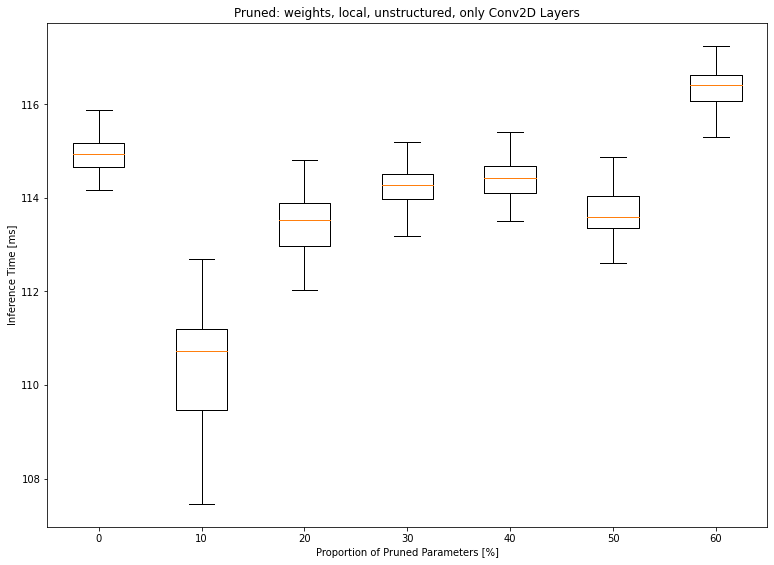

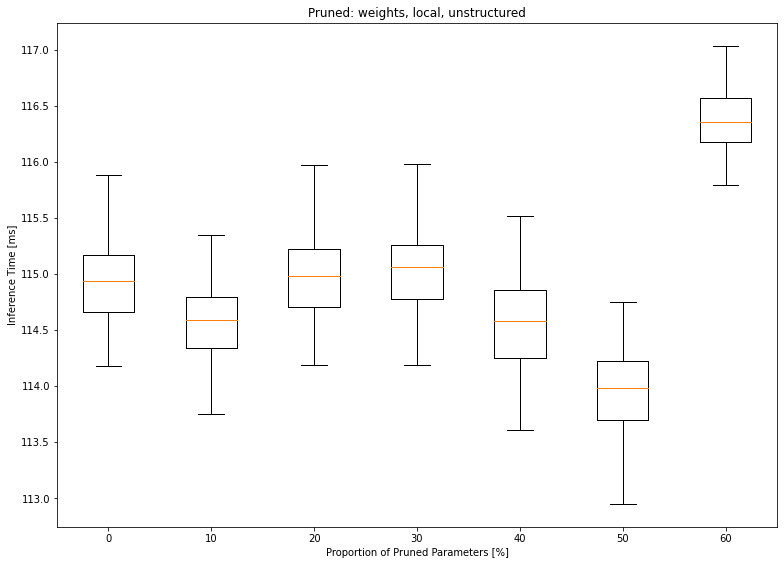

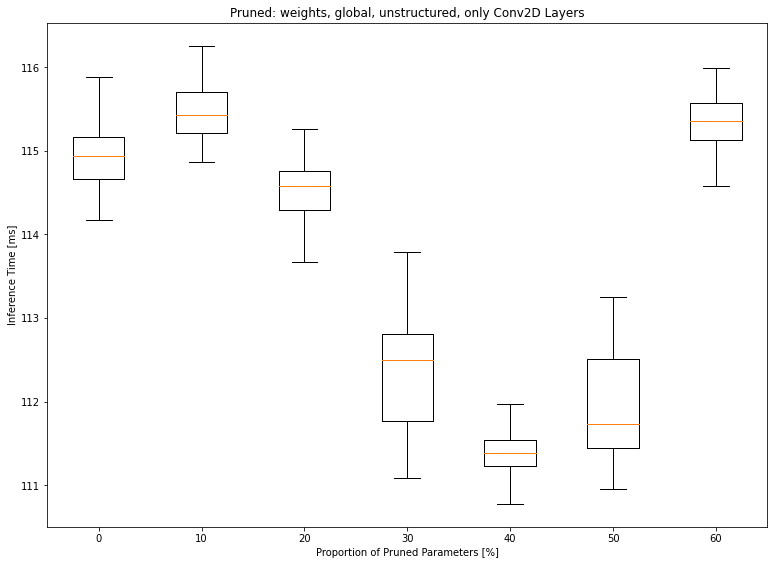

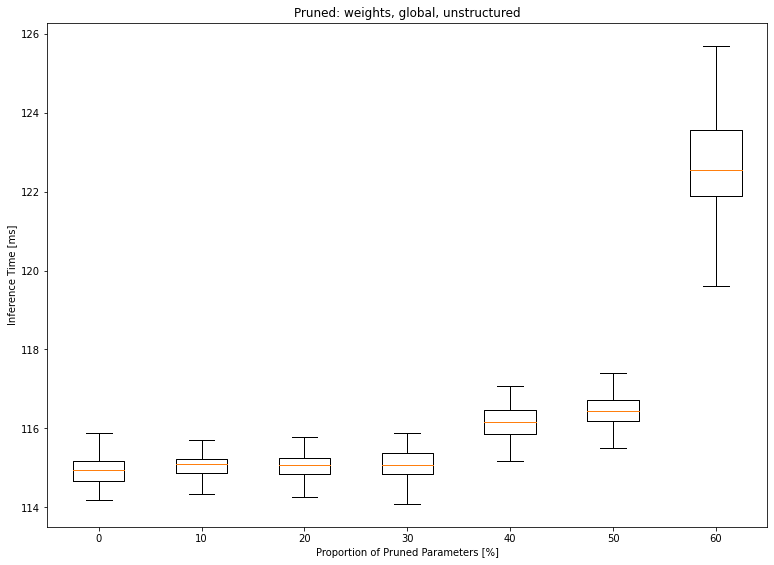

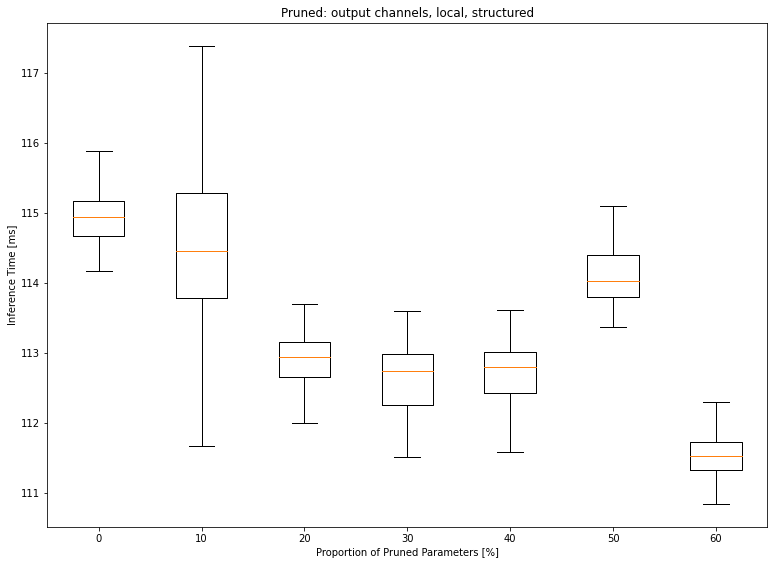

In [ ]:
# Weights-local-unstructured-only Conv2D Layers
data_0 = np.array(inferenceTimes[-1]['inferenceTimes'])
data_10 = np.array(inferenceTimes[0]['inferenceTimes'])
data_20 = np.array(inferenceTimes[1]['inferenceTimes'])
data_30 = np.array(inferenceTimes[2]['inferenceTimes'])
data_40 = np.array(inferenceTimes[3]['inferenceTimes'])
data_50 = np.array(inferenceTimes[4]['inferenceTimes'])
data_60 = np.array(inferenceTimes[5]['inferenceTimes'])
data_pruned_weights_local_unstructured_onlyConv2DLayers = [data_0, data_10, data_20, data_30, data_40, data_50, data_60]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Inference Time [ms]')
bp = ax.boxplot(data_pruned_weights_local_unstructured_onlyConv2DLayers, 0, '')
plt.title("Pruned: weights, local, unstructured, only Conv2D Layers")
plt.show()

# Weights-local-unstructured-all
data_0 = np.array(inferenceTimes[-1]['inferenceTimes'])
data_10 = np.array(inferenceTimes[6]['inferenceTimes'])
data_20 = np.array(inferenceTimes[7]['inferenceTimes'])
data_30 = np.array(inferenceTimes[8]['inferenceTimes'])
data_40 = np.array(inferenceTimes[9]['inferenceTimes'])
data_50 = np.array(inferenceTimes[10]['inferenceTimes'])
data_60 = np.array(inferenceTimes[11]['inferenceTimes'])
data_pruned_weights_local_unstructured_all = [data_0, data_10, data_20, data_30, data_40, data_50, data_60]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Inference Time [ms]')
bp = ax.boxplot(data_pruned_weights_local_unstructured_all, 0, '')
plt.title("Pruned: weights, local, unstructured")
plt.show()

# Weights-global-unstructured-only Conv2D Layers
data_0 = np.array(inferenceTimes[-1]['inferenceTimes'])
data_10 = np.array(inferenceTimes[12]['inferenceTimes'])
data_20 = np.array(inferenceTimes[13]['inferenceTimes'])
data_30 = np.array(inferenceTimes[14]['inferenceTimes'])
data_40 = np.array(inferenceTimes[15]['inferenceTimes'])
data_50 = np.array(inferenceTimes[16]['inferenceTimes'])
data_60 = np.array(inferenceTimes[17]['inferenceTimes'])
data_pruned_weights_global_unstructured_onlyConv2DLayers = [data_0, data_10, data_20, data_30, data_40, data_50, data_60]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Inference Time [ms]')
bp = ax.boxplot(data_pruned_weights_global_unstructured_onlyConv2DLayers, 0, '')
plt.title("Pruned: weights, global, unstructured, only Conv2D Layers")
plt.show()

# Weights-global-unstructured-all
data_0 = np.array(inferenceTimes[-1]['inferenceTimes'])
data_10 = np.array(inferenceTimes[18]['inferenceTimes'])
data_20 = np.array(inferenceTimes[19]['inferenceTimes'])
data_30 = np.array(inferenceTimes[20]['inferenceTimes'])
data_40 = np.array(inferenceTimes[21]['inferenceTimes'])
data_50 = np.array(inferenceTimes[22]['inferenceTimes'])
data_60 = np.array(inferenceTimes[23]['inferenceTimes'])
data_pruned_weights_global_unstructured_all = [data_0, data_10, data_20, data_30, data_40, data_50, data_60]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Inference Time [ms]')
bp = ax.boxplot(data_pruned_weights_global_unstructured_all, 0, '')
plt.title("Pruned: weights, global, unstructured")
plt.show()

# Output Channales-local-structured
data_0 = np.array(inferenceTimes[-1]['inferenceTimes'])
data_10 = np.array(inferenceTimes[24]['inferenceTimes'])
data_20 = np.array(inferenceTimes[25]['inferenceTimes'])
data_30 = np.array(inferenceTimes[26]['inferenceTimes'])
data_40 = np.array(inferenceTimes[27]['inferenceTimes'])
data_50 = np.array(inferenceTimes[28]['inferenceTimes'])
data_60 = np.array(inferenceTimes[29]['inferenceTimes'])
data_pruned_outputChannels_local_structured = [data_0, data_10, data_20, data_30, data_40, data_50, data_60]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Inference Time [ms]')
bp = ax.boxplot(data_pruned_outputChannels_local_structured, 0, '')
plt.title("Pruned: output channels, local, structured")
plt.show()

## compresson ratio

In [ ]:
evaluations = readJson(file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json")

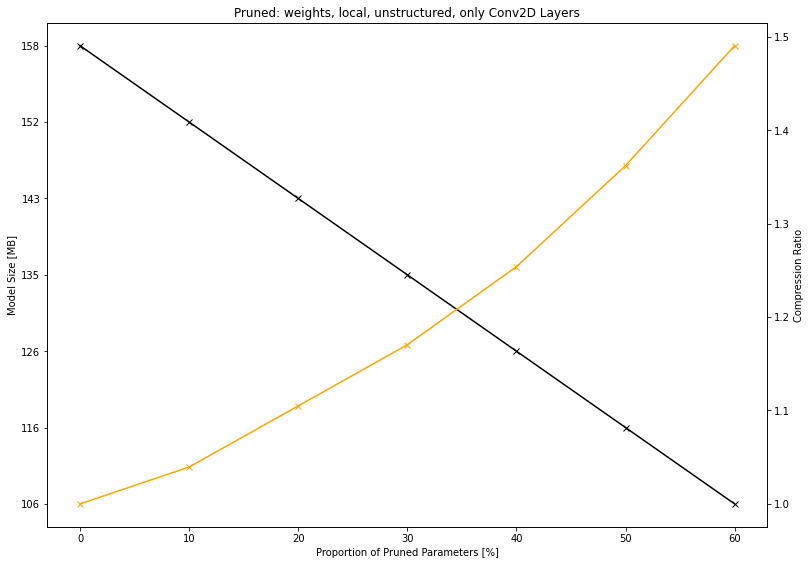

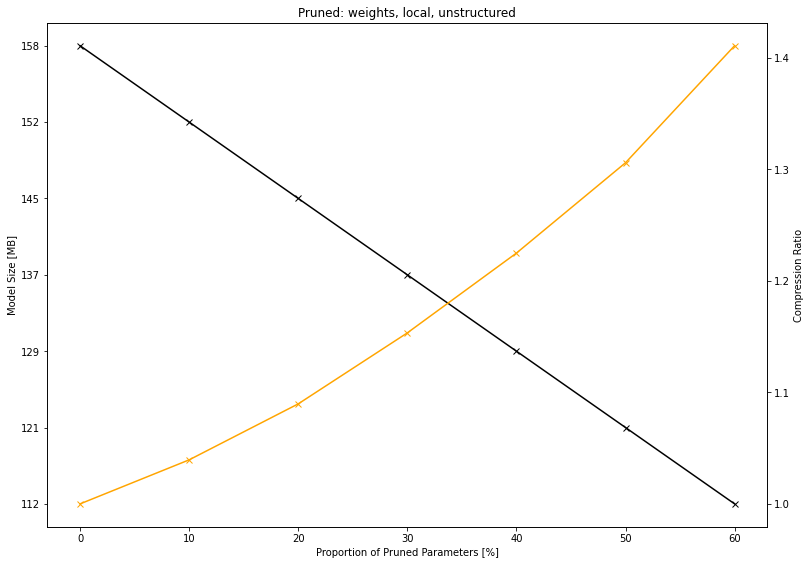

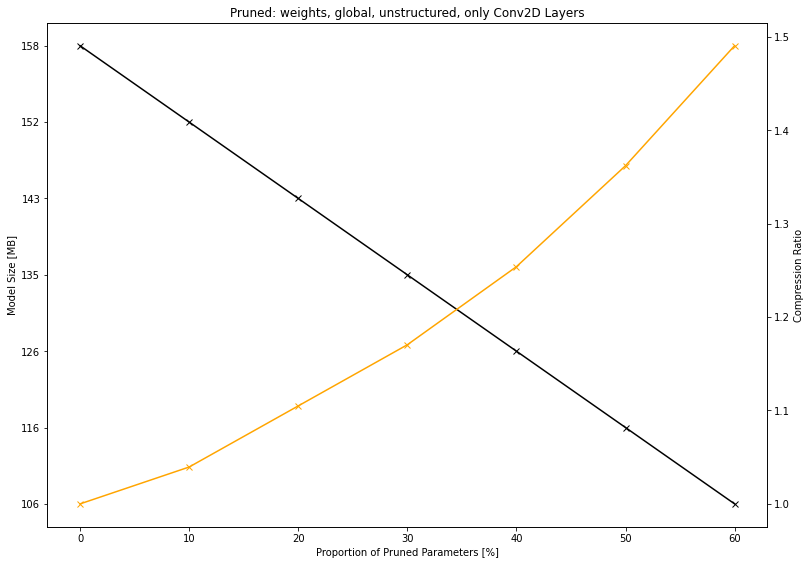

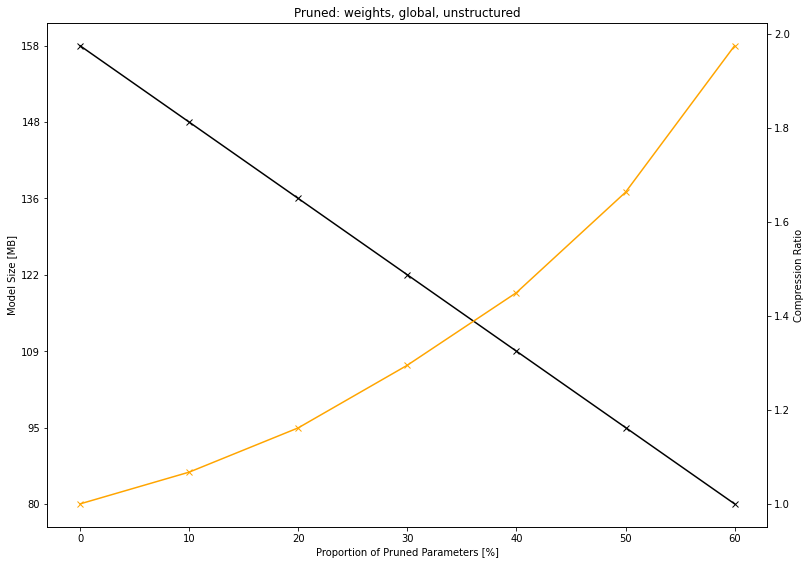

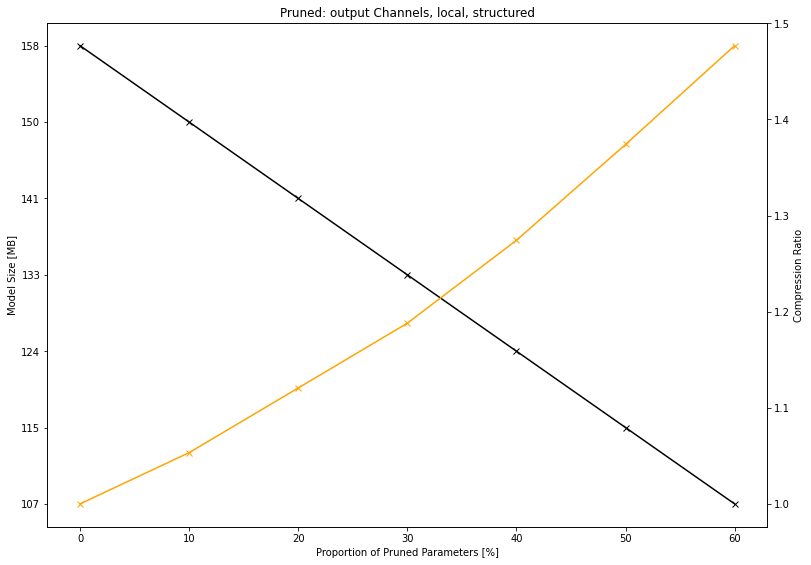

In [ ]:
data_0_size = evaluations[0]['evaluations'][0]['size_compressed']

# Weights-local-unstructured-only Conv2D Layers
data_10_size_compressed = evaluations[1]['evaluations'][0]['size_compressed']
data_10_compression_ratio = int(data_0_size)/ int(data_10_size_compressed)
data_20_size_compressed = evaluations[2]['evaluations'][0]['size_compressed']
data_20_compression_ratio = int(data_0_size)/ int(data_20_size_compressed)
data_30_size_compressed = evaluations[3]['evaluations'][0]['size_compressed']
data_30_compression_ratio = int(data_0_size)/ int(data_30_size_compressed)
data_40_size_compressed = evaluations[4]['evaluations'][0]['size_compressed']
data_40_compression_ratio = int(data_0_size)/ int(data_40_size_compressed)
data_50_size_compressed = evaluations[5]['evaluations'][0]['size_compressed']
data_50_compression_ratio = int(data_0_size)/ int(data_50_size_compressed)
data_60_size_compressed = evaluations[6]['evaluations'][0]['size_compressed']
data_60_compression_ratio = int(data_0_size)/ int(data_60_size_compressed)

data_size_compressed = [data_0_size, data_10_size_compressed, data_20_size_compressed, data_30_size_compressed, data_40_size_compressed, data_50_size_compressed, data_60_size_compressed]
data_compression_ratio = [1, data_10_compression_ratio, data_20_compression_ratio, data_30_compression_ratio, data_40_compression_ratio, data_50_compression_ratio, data_60_compression_ratio]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_size_compressed, color="black", marker="x")
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Model Size [MB]')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.plot(data_compression_ratio, color="orange", marker="x")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax2.set_ylabel('Compression Ratio')
plt.title("Pruned: weights, local, unstructured, only Conv2D Layers")
plt.show()

# Weights-local-unstructured-all
data_10_size_compressed = evaluations[10]['evaluations'][0]['size_compressed']
data_10_compression_ratio = int(data_0_size)/ int(data_10_size_compressed)
data_20_size_compressed = evaluations[11]['evaluations'][0]['size_compressed']
data_20_compression_ratio = int(data_0_size)/ int(data_20_size_compressed)
data_30_size_compressed = evaluations[12]['evaluations'][0]['size_compressed']
data_30_compression_ratio = int(data_0_size)/ int(data_30_size_compressed)
data_40_size_compressed = evaluations[13]['evaluations'][0]['size_compressed']
data_40_compression_ratio = int(data_0_size)/ int(data_40_size_compressed)
data_50_size_compressed = evaluations[14]['evaluations'][0]['size_compressed']
data_50_compression_ratio = int(data_0_size)/ int(data_50_size_compressed)
data_60_size_compressed = evaluations[15]['evaluations'][0]['size_compressed']
data_60_compression_ratio = int(data_0_size)/ int(data_60_size_compressed)

data_size_compressed = [data_0_size, data_10_size_compressed, data_20_size_compressed, data_30_size_compressed, data_40_size_compressed, data_50_size_compressed, data_60_size_compressed]
data_compression_ratio = [1, data_10_compression_ratio, data_20_compression_ratio, data_30_compression_ratio, data_40_compression_ratio, data_50_compression_ratio, data_60_compression_ratio]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_size_compressed, color="black", marker="x")
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Model Size [MB]')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.plot(data_compression_ratio, color="orange", marker="x")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax2.set_ylabel('Compression Ratio')
plt.title("Pruned: weights, local, unstructured")
plt.show()

# Weights-global-unstructured-only Conv2D Layers
data_10_size_compressed = evaluations[16]['evaluations'][0]['size_compressed']
data_10_compression_ratio = int(data_0_size)/ int(data_10_size_compressed)
data_20_size_compressed = evaluations[17]['evaluations'][0]['size_compressed']
data_20_compression_ratio = int(data_0_size)/ int(data_20_size_compressed)
data_30_size_compressed = evaluations[18]['evaluations'][0]['size_compressed']
data_30_compression_ratio = int(data_0_size)/ int(data_30_size_compressed)
data_40_size_compressed = evaluations[19]['evaluations'][0]['size_compressed']
data_40_compression_ratio = int(data_0_size)/ int(data_40_size_compressed)
data_50_size_compressed = evaluations[20]['evaluations'][0]['size_compressed']
data_50_compression_ratio = int(data_0_size)/ int(data_50_size_compressed)
data_60_size_compressed = evaluations[21]['evaluations'][0]['size_compressed']
data_60_compression_ratio = int(data_0_size)/ int(data_60_size_compressed)

data_size_compressed = [data_0_size, data_10_size_compressed, data_20_size_compressed, data_30_size_compressed, data_40_size_compressed, data_50_size_compressed, data_60_size_compressed]
data_compression_ratio = [1, data_10_compression_ratio, data_20_compression_ratio, data_30_compression_ratio, data_40_compression_ratio, data_50_compression_ratio, data_60_compression_ratio]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_size_compressed, color="black", marker="x")
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Model Size [MB]')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.plot(data_compression_ratio, color="orange", marker="x")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax2.set_ylabel('Compression Ratio')
plt.title("Pruned: weights, global, unstructured, only Conv2D Layers")
plt.show()

# Weights-global-unstructured-all
data_10_size_compressed = evaluations[22]['evaluations'][0]['size_compressed']
data_10_compression_ratio = int(data_0_size)/ int(data_10_size_compressed)
data_20_size_compressed = evaluations[23]['evaluations'][0]['size_compressed']
data_20_compression_ratio = int(data_0_size)/ int(data_20_size_compressed)
data_30_size_compressed = evaluations[24]['evaluations'][0]['size_compressed']
data_30_compression_ratio = int(data_0_size)/ int(data_30_size_compressed)
data_40_size_compressed = evaluations[25]['evaluations'][0]['size_compressed']
data_40_compression_ratio = int(data_0_size)/ int(data_40_size_compressed)
data_50_size_compressed = evaluations[26]['evaluations'][0]['size_compressed']
data_50_compression_ratio = int(data_0_size)/ int(data_50_size_compressed)
data_60_size_compressed = evaluations[27]['evaluations'][0]['size_compressed']
data_60_compression_ratio = int(data_0_size)/ int(data_60_size_compressed)

data_size_compressed = [data_0_size, data_10_size_compressed, data_20_size_compressed, data_30_size_compressed, data_40_size_compressed, data_50_size_compressed, data_60_size_compressed]
data_compression_ratio = [1, data_10_compression_ratio, data_20_compression_ratio, data_30_compression_ratio, data_40_compression_ratio, data_50_compression_ratio, data_60_compression_ratio]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_size_compressed, color="black", marker="x")
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Model Size [MB]')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.plot(data_compression_ratio, color="orange", marker="x")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax2.set_ylabel('Compression Ratio')
plt.title("Pruned: weights, global, unstructured")
plt.show()

# Output Channels-local-structured
data_10_size_compressed = evaluations[28]['evaluations'][0]['size_compressed']
data_10_compression_ratio = int(data_0_size)/ int(data_10_size_compressed)
data_20_size_compressed = evaluations[29]['evaluations'][0]['size_compressed']
data_20_compression_ratio = int(data_0_size)/ int(data_20_size_compressed)
data_30_size_compressed = evaluations[30]['evaluations'][0]['size_compressed']
data_30_compression_ratio = int(data_0_size)/ int(data_30_size_compressed)
data_40_size_compressed = evaluations[31]['evaluations'][0]['size_compressed']
data_40_compression_ratio = int(data_0_size)/ int(data_40_size_compressed)
data_50_size_compressed = evaluations[32]['evaluations'][0]['size_compressed']
data_50_compression_ratio = int(data_0_size)/ int(data_50_size_compressed)
data_60_size_compressed = evaluations[33]['evaluations'][0]['size_compressed']
data_60_compression_ratio = int(data_0_size)/ int(data_60_size_compressed)

data_size_compressed = [data_0_size, data_10_size_compressed, data_20_size_compressed, data_30_size_compressed, data_40_size_compressed, data_50_size_compressed, data_60_size_compressed]
data_compression_ratio = [1, data_10_compression_ratio, data_20_compression_ratio, data_30_compression_ratio, data_40_compression_ratio, data_50_compression_ratio, data_60_compression_ratio]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_size_compressed, color="black", marker="x")
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Model Size [MB]')
ax.invert_yaxis()
ax2 = ax.twinx()
ax2.plot(data_compression_ratio, color="orange", marker="x")
ax2.tick_params(axis='y', labelcolor="black")
ax2.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax2.set_ylabel('Compression Ratio')
plt.title("Pruned: output Channels, local, structured")
plt.show()

## Average Precision

In [ ]:
evaluations = readJson(file_path = "/content/drive/MyDrive/DHBW/BA/ProductiveResults/EvaluationOutput.json")

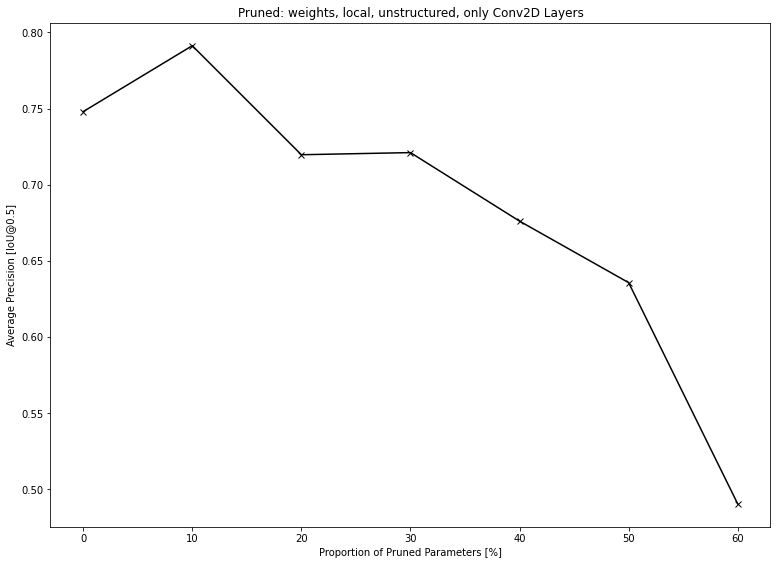

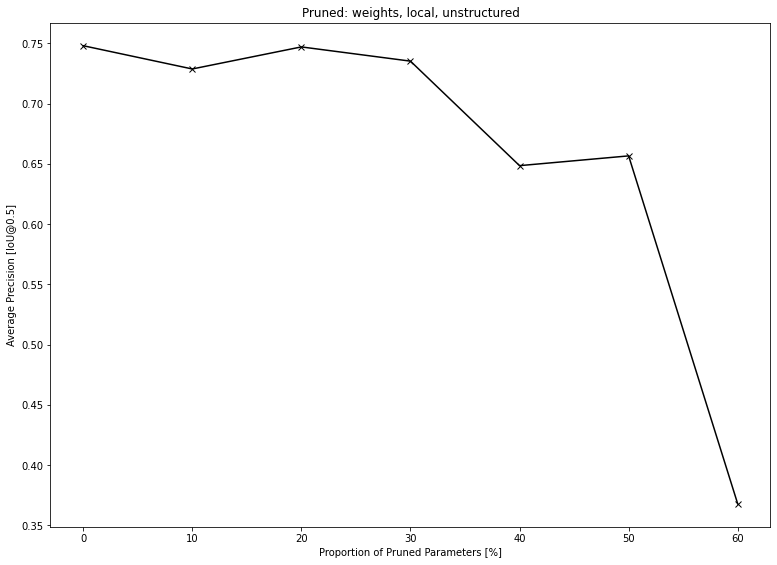

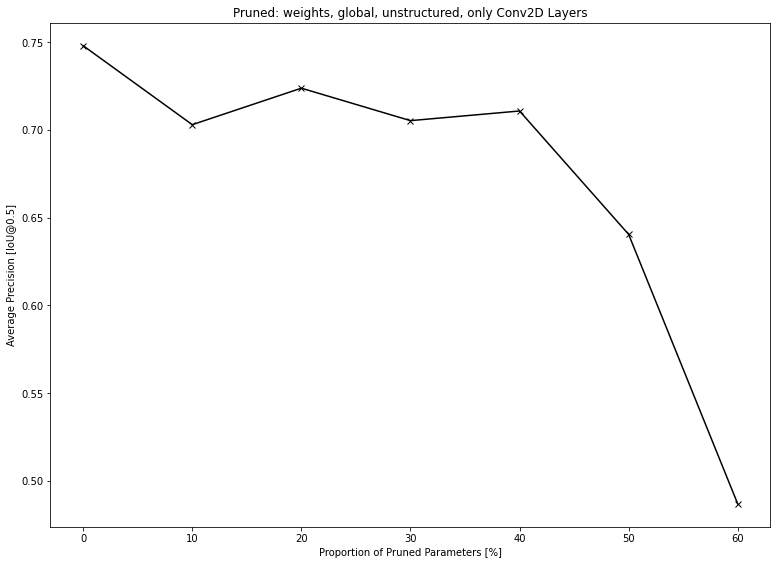

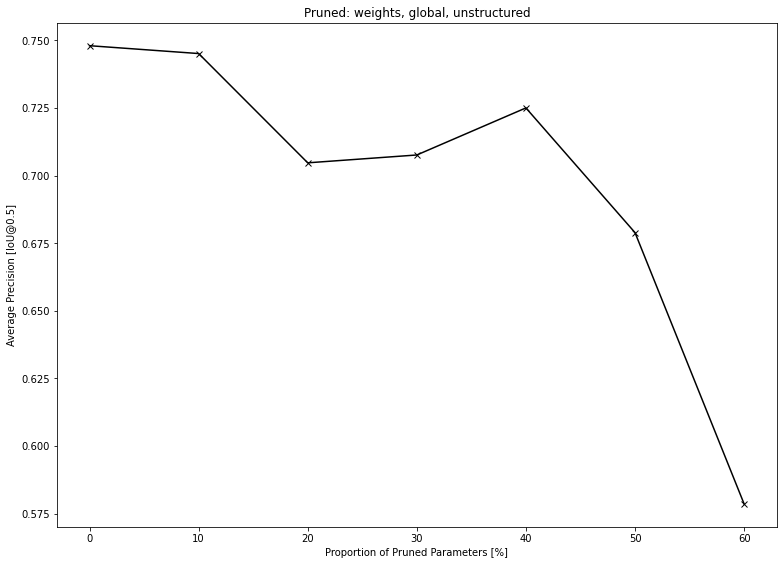

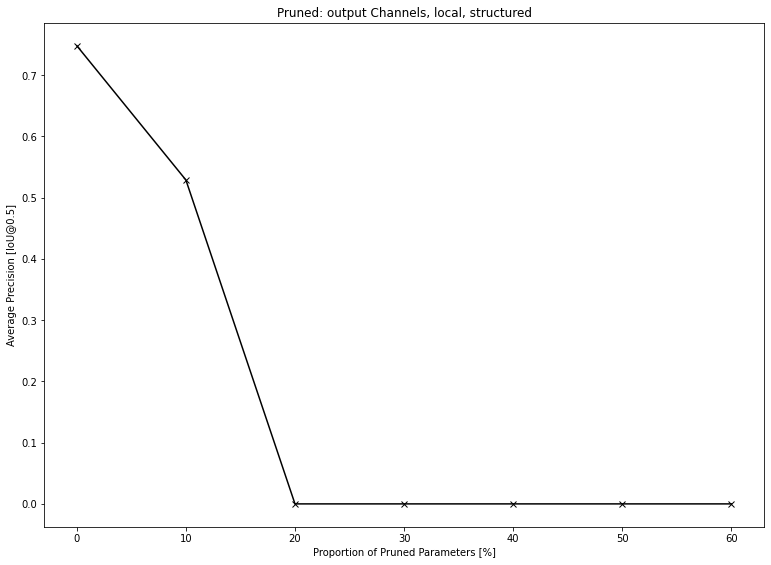

In [ ]:
data_0_mAP = evaluations[0]['evaluations'][0]['mAP[IoU@0.5]']

# Weights-local-unstructured-only Conv2D Layers
data_10_mAP = evaluations[1]['evaluations'][0]['mAP[IoU@0.5]']
data_20_mAP = evaluations[2]['evaluations'][0]['mAP[IoU@0.5]']
data_30_mAP = evaluations[3]['evaluations'][0]['mAP[IoU@0.5]']
data_40_mAP = evaluations[4]['evaluations'][0]['mAP[IoU@0.5]']
data_50_mAP = evaluations[5]['evaluations'][0]['mAP[IoU@0.5]']
data_60_mAP = evaluations[6]['evaluations'][0]['mAP[IoU@0.5]']

data_mAP = [data_0_mAP,data_10_mAP,data_20_mAP,data_30_mAP,data_40_mAP,data_50_mAP,data_60_mAP]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_mAP, color="black", marker='x')
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Average Precision [IoU@0.5]')
plt.title("Pruned: weights, local, unstructured, only Conv2D Layers")
plt.show()

# Weights-local-unstructured-all
data_10_mAP = evaluations[10]['evaluations'][0]['mAP[IoU@0.5]']
data_20_mAP = evaluations[11]['evaluations'][0]['mAP[IoU@0.5]']
data_30_mAP = evaluations[12]['evaluations'][0]['mAP[IoU@0.5]']
data_40_mAP = evaluations[13]['evaluations'][0]['mAP[IoU@0.5]']
data_50_mAP = evaluations[14]['evaluations'][0]['mAP[IoU@0.5]']
data_60_mAP = evaluations[15]['evaluations'][0]['mAP[IoU@0.5]']

data_mAP = [data_0_mAP,data_10_mAP,data_20_mAP,data_30_mAP,data_40_mAP,data_50_mAP,data_60_mAP]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_mAP, color="black", marker='x')
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Average Precision [IoU@0.5]')
plt.title("Pruned: weights, local, unstructured")
plt.show()

# Weights-global-unstructured-only Conv2D Layers
data_10_mAP = evaluations[16]['evaluations'][0]['mAP[IoU@0.5]']
data_20_mAP = evaluations[17]['evaluations'][0]['mAP[IoU@0.5]']
data_30_mAP = evaluations[18]['evaluations'][0]['mAP[IoU@0.5]']
data_40_mAP = evaluations[19]['evaluations'][0]['mAP[IoU@0.5]']
data_50_mAP = evaluations[20]['evaluations'][0]['mAP[IoU@0.5]']
data_60_mAP = evaluations[21]['evaluations'][0]['mAP[IoU@0.5]']

data_mAP = [data_0_mAP,data_10_mAP,data_20_mAP,data_30_mAP,data_40_mAP,data_50_mAP,data_60_mAP]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_mAP, color="black", marker='x')
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Average Precision [IoU@0.5]')
plt.title("Pruned: weights, global, unstructured, only Conv2D Layers")
plt.show()

# Weights-global-unstructured-all
data_10_mAP = evaluations[22]['evaluations'][0]['mAP[IoU@0.5]']
data_20_mAP = evaluations[23]['evaluations'][0]['mAP[IoU@0.5]']
data_30_mAP = evaluations[24]['evaluations'][0]['mAP[IoU@0.5]']
data_40_mAP = evaluations[25]['evaluations'][0]['mAP[IoU@0.5]']
data_50_mAP = evaluations[26]['evaluations'][0]['mAP[IoU@0.5]']
data_60_mAP = evaluations[27]['evaluations'][0]['mAP[IoU@0.5]']

data_mAP = [data_0_mAP,data_10_mAP,data_20_mAP,data_30_mAP,data_40_mAP,data_50_mAP,data_60_mAP]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_mAP, color="black", marker='x')
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Average Precision [IoU@0.5]')
plt.title("Pruned: weights, global, unstructured")
plt.show()

# Output Channels-local-structured
data_10_mAP = evaluations[28]['evaluations'][0]['mAP[IoU@0.5]']
data_20_mAP = evaluations[29]['evaluations'][0]['mAP[IoU@0.5]']
data_30_mAP = evaluations[30]['evaluations'][0]['mAP[IoU@0.5]']
data_40_mAP = evaluations[31]['evaluations'][0]['mAP[IoU@0.5]']
data_50_mAP = evaluations[32]['evaluations'][0]['mAP[IoU@0.5]']
data_60_mAP = evaluations[33]['evaluations'][0]['mAP[IoU@0.5]']

data_mAP = [data_0_mAP,data_10_mAP,data_20_mAP,data_30_mAP,data_40_mAP,data_50_mAP,data_60_mAP]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(data_mAP, color="black", marker='x')
ax.tick_params(axis='y', labelcolor="black")
ax.set_xticklabels(['0','0','10', '20', '30', '40', '50', '60'])
ax.set_xlabel('Proportion of Pruned Parameters [%]')
ax.set_ylabel('Average Precision [IoU@0.5]')
plt.title("Pruned: output Channels, local, structured")
plt.show()
